<img align="center" style="max-width: 1000px" src="banner.png">

<img align="right" style="max-width: 200px; height: auto" src="hsg_logo.png">

##  Lab 05 - Residual Neural Networks (ResNets) (Bonus)

GSERM Summer School 2023, Deep Learning: Fundamentals and Applications, University of St. Gallen

In the last lab you learned about how to utilize a **supervised** (deep) machine learning technique, namely **Convolutional Neural Networks (CNNs)**, to classify tiny images of different objects (birds, ships..) contained in the **CIFAR-10** dataset. 

**CNN**s are a special type of deep neural network that work particularly well on spatial data, as they break down and capture complex patterns which can be used to classify the content of an image.

In this lab, we will examine a more recent technique called **Residual Neural Networks (ResNets)**, an extension of **CNNs**. In general, the data contains low / medium / high-level features that are learned by a neural network and used for classification. The analysis and processing of these features can be extended by adding more depth to a network, i.e. increasing the number of layers it contains. However, adding more depth is not as easy as it sounds. **ResNets** are motivated by the will to add depth to deep classifiers and by the difficulty that this entails.

In short, a **ResNet** allows the training of much deeper neural networks by stacking **Residual Blocks** on top of each other. These blocks allow the activation layers used throughout the network to be fast-forwarded to deeper layers in the network - which ultimately helps the network solve what is known as the *vanishing gradient* problem. Essentially, this problem is one of the challenges of training deep networks. But more on that in the lab.

We will again use the functionality of the `PyTorch` library to implement and train a **Residual Neural Network**. As in the **CNN** lab, we will use the **CIFAR-10** dataset. The network will thus be trained on a set of tiny images to learn a model of the images' content. Upon successful training, we will utilize the learned RNN model to classify so far unseen tiny images into distinct categories such as aeroplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

The figure below illustrates a high-level view on the machine learning process we aim to establish in this lab:

<img align="center" style="max-width: 900px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/pipeline.png?raw=1">

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

## 1. Lab Objectives:

After today's lab, you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Residual Neural Networks (CNNs)**.
> 2. Know how to **implement and to train a RNN** to learn a model of tiny image data.
> 3. Understand how to apply such a learned model to **classify images** images based on their content into distinct categories.
> 4. Know how to **interpret and visualize** the model's classification results.

Before we start let's watch a motivational video:

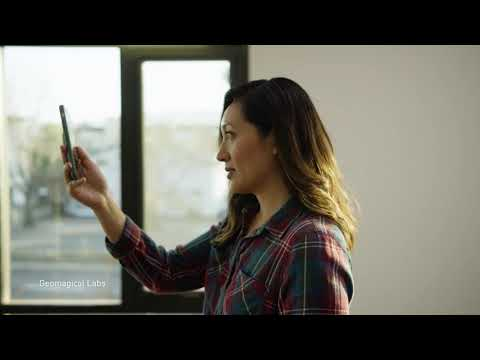

In [1]:
from IPython.display import YouTubeVideo
#NVIDIA: "Reinventing Retail with AI | I AM AI"
YouTubeVideo('RAzohJygdmc', width=800, height=600)

## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the `PyTorch`, `Numpy`, `Sklearn`, `Matplotlib`, `Seaborn` and a few utility libraries throughout this lab:

In [2]:
# import standard python libraries
import os, urllib, io
from datetime import datetime
import numpy as np

Import Python machine / deep learning libraries:

In [3]:
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/usr/local/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/usr/local/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/usr/local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")


Import the sklearn classification metrics:

In [4]:
# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import confusion_matrix 

Import Python plotting libraries:

In [5]:
# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Enable notebook matplotlib inline plotting:

In [6]:
%matplotlib inline

Create notebook folder structure to store the data as well as the trained neural network models:

In [7]:
if not os.path.exists('./data'): os.makedirs('./resnet_data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./resnet_models')  # create trained models directory

Set a random `seed` value to obtain reproducable results:

In [8]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

## 3. Dataset Download and Data Assessment

The **CIFAR-10 database** (**C**anadian **I**nstitute **F**or **A**dvanced **R**esearch) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The database is widely used to conduct computer vision research using machine learning and deep learning methods:

<img align="center" style="max-width: 500px; height: 500px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/cifar10.png?raw=1">

(Source: https://www.kaggle.com/c/cifar-10)

Further details on the dataset can be obtained via: *Krizhevsky, A., 2009. "Learning Multiple Layers of Features from Tiny Images",  
( https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf )."*

The CIFAR-10 database contains **60,000 color images** (50,000 training images and 10,000 validation images). The size of each image is 32 by 32 pixels. The collection of images encompasses 10 different classes that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Let's define the distinct classs for further analytics:

In [9]:
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Thereby the dataset contains 6,000 images for each of the ten classes. The CIFAR-10 is a straightforward dataset that can be used to teach a computer how to recognize objects in images.

Let's download, transform and inspect the training images of the dataset. Therefore, we first will define the directory we aim to store the training data:

In [10]:
train_path = './data/train_cifar10'

Now, let's download the training data accordingly:

In [11]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and transform training images
cifar10_train_data = torchvision.datasets.CIFAR10(root=train_path, train=True, transform=transf, download=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:52<00:00, 3249116.86it/s]


Extracting ./data/train_cifar10/cifar-10-python.tar.gz to ./data/train_cifar10


Verify the volume of training images downloaded:

In [12]:
# get the length of the training data
len(cifar10_train_data)

50000

Furthermore, let's investigate a couple of the training images:

In [13]:
# set (random) image id
image_id = 1800

# retrieve image exhibiting the image id
cifar10_train_data[image_id]

(tensor([[[ 0.0118, -0.0039,  0.0118,  ...,  0.0353,  0.0353,  0.0275],
          [ 0.0039,  0.0039,  0.0118,  ...,  0.0275,  0.0275,  0.0196],
          [ 0.0196,  0.0039,  0.0196,  ...,  0.0431,  0.0353,  0.0353],
          ...,
          [-0.2000, -0.2627, -0.4745,  ...,  0.0510,  0.0353,  0.0275],
          [-0.1529, -0.2471, -0.3725,  ...,  0.0431,  0.0275,  0.0196],
          [-0.1373, -0.3725, -0.4902,  ...,  0.0275,  0.0196,  0.0118]],
 
         [[ 0.1922,  0.1765,  0.1922,  ...,  0.2000,  0.2000,  0.1922],
          [ 0.1922,  0.1843,  0.1922,  ...,  0.1922,  0.1922,  0.1843],
          [ 0.2000,  0.1843,  0.2000,  ...,  0.2078,  0.2000,  0.2000],
          ...,
          [-0.1137, -0.1843, -0.4667,  ...,  0.2314,  0.2157,  0.2078],
          [-0.0667, -0.1451, -0.3569,  ...,  0.2235,  0.2078,  0.2000],
          [-0.0588, -0.2471, -0.4588,  ...,  0.2078,  0.2000,  0.1922]],
 
         [[ 0.5451,  0.5216,  0.5373,  ...,  0.5529,  0.5529,  0.5451],
          [ 0.5373,  0.5216,

Ok, that doesn't seem easily interpretable ;) Let's first seperate the image from its label information:

In [14]:
cifar10_train_image, cifar10_train_label = cifar10_train_data[image_id]

Great, now we are able to visually inspect our sample image: 

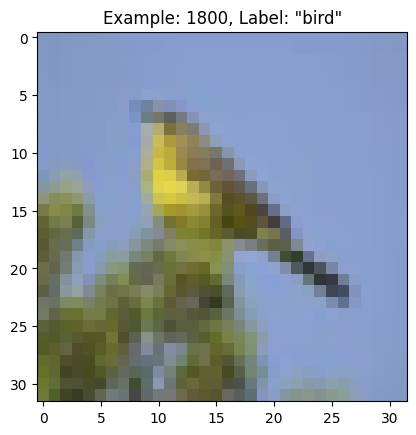

In [15]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: "{}"'.format(str(image_id), str(cifar10_classes[cifar10_train_label])))

# un-normalize cifar 10 image sample
cifar10_train_image_plot = cifar10_train_image / 2.0 + 0.5

# plot 10 image sample
plt.imshow(trans(cifar10_train_image_plot))

Fantastic, right? Let's now decide on where we want to store the evaluation data:

In [16]:
eval_path = './data/eval_cifar10'

And download the evaluation data accordingly:

In [17]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and transform validation images
cifar10_eval_data = torchvision.datasets.CIFAR10(root=eval_path, train=False, transform=transf, download=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:31<00:00, 5388566.39it/s]


Extracting ./data/eval_cifar10/cifar-10-python.tar.gz to ./data/eval_cifar10


Verify the volume of validation images downloaded:

In [18]:
# get the length of the training data
len(cifar10_eval_data)

10000

## 4. Neural Network Implementation

In this section we, will implement the architecture of the **neural network** we aim to utilize to learn a model that is capable of classifying the 32x32 pixel CIFAR 10 images according to the objects contained in each image. We will first examine what **RNNs** are, how they differ from **CNNs** and how they can be built. However, before we start with the theory, let's briefly revisit the process to be established. The following cartoon provides a birds-eye view:

<img align="center" style="max-width: 900px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/pipeline.png?raw=1">

### 4.1 ResNet Theoretical Background

Deep neural networks have led to a series of breakthroughs for image classification. In general, deep networks naturally integrate low / mid / high level features and classifiers in an end-to-end multilayer fashion, and the 'levels' of features can be enriched by the depth (or number of stacked layers) of the network. Driven by the significance of depth, the question arises: **Will stacking more layers improve feature learning and therefore increase the classification capability of a model?**

In 2015, in their work **'Deep Residual Learning for Image Recognition'** He et al. (https://arxiv.org/abs/1512.03385) proposed an enhanced deep convolutional neural network architecture. The architecture is referred to as **Residual Neural Networks** since it encompasses so called **Residual Layers** or **Residual Blocks**. Using this architecture, He et al. demonstrated that they were able to outperform a variety of image classification benchmark challenges at the time. We have a closer look into the distinct characteristic of the architecture on the following section of the notebook.

#### 4.1.1 CNN Recap

Before we dive into **RNNs**, let's briefly revisit **Convolutional Neural Networks (CNNs)** as they are the basis for **RNNs**. Here is a birds-eye view of the CNN we built in the previous lab:

<img align="center" style="max-width: 900px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/cnn_pipeline.png?raw=1">

(Image of the CNN architecture created via http://alexlenail.me/)

Our CNN consisted of two **convolutional layers** and three **fully-connected layers**. In general, convolutional layers are specifically designed to learn a set of **high-level features** ("patterns") in the processed images, e.g., tiny edges and shapes. The fully-connected layers utilize the learned features to learn **non-linear feature combinations** that allow for highly accurate classification of the image content into the different image classes of the CIFAR-10 dataset, such as, birds, aeroplanes, horses etc.

The implementation of these **convolutional layers** involves three operations: (1) **convolution**, (2) **non-linearity**, and (3) **max-pooling**. Those operations are usually executed in sequential order during the forward pass through a convolutional layer.

Here is a graphical illustration of convolutional layers:

<img align="center" style="max-width: 600px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/convolutions.png?raw=1">

To perform a convolution, a **kernel** is used. A kernel is a small matrix of size 5x5 for example, which we horizontally and vertically slide along the image. We then obtain a dot product of the kernel and the pixel values of the kernel's receptive field. The results of these dot products are then summed up and found in the operation's output.

When sliding a given kernel on an image, two elements are particularly important: the **stride** designates the number of pixels a kernel passes when moving, and the **padding** adds a given number of (blank) pixels on the sides of an image to ensure that the output has the same shape as the input.

The last step of a convolutional layer is the application of a **pooling** operation. These are done in **Max-Pooling Layers**, where max-pooling is a type of pooling. Pooling reduces the size of feature maps (images), and gives the ability to ignore positional shifts or translations in the target image by doing so. A truck is a truck, independently of its position. In short, it down-samples the image.

This is done by (again) defining a kernel (usually 2x2 or 3x3), which is slid along the image (like in a convolution). In Max-Pooling, we only keep the highest pixel value within the receptive field of the kernel.

After having performed the convolutional operations, the network turns to **fully connected layers**. Here is an overview:

<img align="center" style="max-width: 600px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/fullyconnected.png?raw=1">

After the output of the last max-pooling layer has been flattened (to enable connection), we can safely proceed with our fully connected layers. The fully connected layers use activations functions (e.g. **ReLU**) to learn potential non-linear feature combinations. They follow a brute-force concept where all inputs from one layer are connected to every activation unit of the next.

Finally, a **Softmax** function normalizes our output into a probability distribution consisting of K probabilities, where K is the number of distinct classes. These probabilities can be interpreted as the probability that an image belongs to given classes.

#### 4.1.2 Residual Blocks

The goal of **Residual Neural Networks** is to ease the training of networks that are a lot deeper (where more layers are stacked on top of each other). The training of very deep neural networks is difficult because of several problems. One is of course the computational cost, but there also exists the so-called **"vanishing gradient problem"** - or **"degradation problem"**. This denotes a weird phenomenon: as network depth increases, accuracy converges and saturates, but then rapidly degrades. This problem is "*not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error*" (He et al., 2015, p.1).

A **residual block** or **residual layer** is a group of layers for which the same activation is used. This is done by fast-forwarding the activation to a further layer in the neural network. These fast-forwards are also called **skip-connections** or **shortcuts** - taking the activation from one layer and using it deeper. It is this concept that allows the training of very deep (e.g. even more than 100 layers) networks.

Here is a more mathematical explanation:

<img align="center" style="max-width: 600px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/main_vs_resnet_paths.png?raw=1">

Credit: "C4W2L03 Resnets" by Andrew Ng at Deeplearning.ai, https://www.youtube.com/watch?v=ZILIbUvp5lk

The **"normal"** path from layer to layer is represented in the top half of the above image. The input $x^{[l]}$ for a given layer goes through a Linear operator which computes $z^{[l+1]}$. After this, a non-linearity is applied (we use **ReLU** in our example) to get $x^{[l+1]}$. Then, $x^{[l+1]}$ is fed to another Linear layer to get $z^{[l+2]}$, which is again given to a non-linearity to get $x^{[l+2]}$.

The steps of the normal path in more detail:
>- Start off with $x^{[l]}$
>- Compute $z^{[l+1]} = W^{[l+1]}* x^{[l]} + b^{[l+1]}$, where $W$ is the weight matrix and $b$ is the bias vector. This operation constitutes the Linearity.
>- Feed $z^{[l+1]}$ to the activation function $g$ to get $x^{[l+1]}$. $x^{[l+1]} = g(z^{[l+1]})$. This is the non-linearity.
>- Compute $z^{[l+2]} = W^{[l+2]}*x^{[l+1]}+b^{[l+2]}$, the second Linearity.
>- Get $x^{[l+2]} = g(z^{[l+2]})$, by again using the ReLU non-linearity.

The *vanishing gradient problem* simply denotes that the application of the non-linearity (ReLU) results in information loss. Information about the original state of the image is modified by ReLU when it arrives to the next layer. After a certain point (a certain depth/number of layers), this problem is such that the model's performance is actually worse. This is why we experience problems by increasing the **CNN**'s depth.

In **RNNs**, the idea is that every additional layer should more easily contain the identity function as one of its elements. With the identity function $f(x) = x$, gradients at every layer are computed with the original input taken into account. By using this identity function, information is not lost, which means that adding another layer to the model, theoretically, can only reduce training error or keep it the same.

<img align="center" style="max-width: 600px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/normal_vs_residual_block.png?raw=1">

Sources: 
>- He, K., Zhang, X., Ren, S., and, Sun, J. (2015). Deep Residual Learning for Image Recognition
>- Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2020). Dive into Deep Learning. Available at https://d2l.ai/index.html

This figure might help illustrate. Let us designate what needs to be learned in a perfect world by $f(x)$, which we will call the desired underlying mapping. This is what will then be fed to the activation function at the top. The schema on the left represents the *normal* path. The steps within the dotted-line box must directly learn the mapping $f(x)$. The steps within the dotted-line box from the schema on the right (the RNN path), however, aim at learning the **residual mapping $f(x) - x$**. 

We can do this because, as put in the original paper, "if one hypothesizes that multiple nonlinear layers can asymptotically approximate complicated functions, then it is equivalent to hypothesize that they can asymptotically approximate the residual functions" (He et al., 2015, p.3).

 **$x$**, the **residual**, represents the output from the previous layer which we use as input for the current layer.

After this is done, the original  input **$x$** is added to it to obtain the desired underlying mapping $f(x)$. This is shown by the continuous line transporting **$x$** to the top of the block, just before the activation function - this side-path is the so-called *shortcut* (also called *residual connection* or *skip connection*). This way, no extra computational cost occurs and we avoid information loss, thus enabling deeper networks.

The schema on the right represents a residual block.

If we go back to our math, the operations that take place in a **Residual Block** are as follows:

>- Start off with $x^{[l]}$
>- Instead of making it go through the *normal* path, we select it and fast-forward it to the end of the path, where we add it just before the non-linearity (ReLU). This is the **shortcut**.
>- This means that $x^{[l+2]}$, which was previsouly $x^{[l+2]} = g(z^{[l+2]})$, becomes $x^{[l+2]} = g(z^{[l+2]} {\color{red} {+ x^{[l]}}})$
>- The rest stays the same as in the *normal* path.

Please be sure to notice that $x^{[l]}$ is injected after the linear operation and before the non-linearity (ReLU). This way, the final activation is effectively fast-forwarded to a later stage (i.e., after adding **$x$**).

#### 4.1.3 RNN Architecture Building

Now that we have some intuition as to what a **residual block** is, how it works, and why it is useful, let's see how these can be used. And this is actually quite simple. Like many things in deep learning, we just stack them on top of each other. Here is a visualization:

<img align="center" style="max-width: 600px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/blocks.png?raw=1">

Credit: "C4W2L03 Resnets" by Andrew Ng at Deeplearning.ai, https://www.youtube.com/watch?v=ZILIbUvp5lk

Or, as illustrated in the original paper:

<img align="center" style="max-width: 600px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/resnet_archi.png?raw=1">

Sources: He, K., Zhang, X., Ren, S., and, Sun, J. (2015). Deep Residual Learning for Image Recognition (page 4)

You might notice that some of the shortcuts are drawn with dotted lines. We have assumed thus far that $x^{[l+2]}$ and $x^{[l]}$ had the same dimension. If this is not the case, as sometimes input/output channels change dimensions throughout the network, the $x^{[l+2]} = g(z^{[l+2]} + x^{[l]})$ operation (where we add **$x$** to the residual mapping) will become problematic.

To counter this, we can either avoid changing dimensions as much as possible, or add an extra matrix $Ws$ to the equation, which would become: 
$$x^{[l+2]} = g(z^{[l+2]} + Ws*x^{[l]})$$



Say that $z^{[l+2]}$ and therefore $x^{[l+2]}$ is 256-diemnsional, and that $x^{[l]}$ is 128 dimensional. Then if the extra matrix $Ws$ has dimension $\mathbb{R}^{[256*128]}$, it makes $Ws*x^{[l]}$ 256-dimensional and all is well. This would allow the addition as the matrices would share the same dimensions. That said, what do we actually put in $Ws$? There are two options: it can either be a matrix of parameters we learned, or a fixed matrix that takes $x^{[l]}$ and zero-pads it to make it 256-dimensional. This adjustment is what is represented by dotted lines in the image.

However, this is just a detail so do not worry too much about it.

#### 4.1.4 Training Error Progression

As discussed above and prior to the advent of **RNNs**, training error tended to decrease, saturate and then *increase* along with network depth due to the *vanishing gradient* problem (or *degradation* problem). This is illustrated in the figure below:

<img align="center" style="max-width: 600px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/deep_cnn_error.png?raw=1">

Credit: "C4W2L03 Resnets" by Andrew Ng at Deeplearning.ai, https://www.youtube.com/watch?v=ZILIbUvp5lk

**RNNs** tackle this issue by fighting information loss that occurs during non-linear operations. Learning **residual mappings/functions** with reference to the layer inputs allows the model's accuracy to *at least* not worsen. Thus, the addition of more layers (the deepening of the model) either does not affect training loss or decreases it.

<img align="center" style="max-width: 600px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/rnn_error.png?raw=1">

Credit: "C4W2L03 Resnets" by Andrew Ng at Deeplearning.ai, https://www.youtube.com/watch?v=ZILIbUvp5lk

The theory presented here was based on three amazing **sources**, namely:

>- 'Deep Residual Learning for Image Recognition' by He, K., Zhang, X., Ren, S., and, Sun, J., 2015. Available at https://arxiv.org/pdf/1512.03385.pdf 
>- 'Dive into Deep Learning' by Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2020). Available at https://d2l.ai/index.html
>- Andrew Ng's classes on YouTube: 'C4W2L03 Resnets' and 'C4W2L04 Why ResNets Work' on the Deeplearning.ai channel. Available at https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w and excellent for those who are not big readers.

### 4.2 ResNet Architecture Implementation

In this sub-chapter, we will first build the `ResidualBlock` class. We will be able to call it when we then build the `ResNet` class - our neural network. Since our network achitecture will contain residual blocks, we need to define them in advance. We will finish by instantiating the resulting model.

#### 4.2.1 The Residual Block

As discussed above, a **residual block** simply denotes that the activation of a layer can be fast-forwarded to a deeper layer in the neural network. As you can observe in the image below, the activation from a previous layer is being added to the final activation of a deeper layer in the network.

<img align="center" style="max-width: 400px" src="https://github.com/GitiHubi/courseML/blob/master/lab_06/residual_block.png?raw=1">

Sources: 
>- He, K., Zhang, X., Ren, S., and, Sun, J. (2015). Deep Residual Learning for Image Recognition
>- Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2020). Dive into Deep Learning. Available at https://d2l.ai/index.html

Let's implement such a **Residual Block**, as shown above, using `PyTorch`library. Our block will consist of the exact same structure:

In [19]:
# implement ResNet residual block
class ResidualBlock(nn.Module):

    # define the class constructor
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):

        # call super class constructor
        super(ResidualBlock, self).__init__()

        # init first convolutional layer of residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) # batch-normalization
        self.relu1 = nn.ReLU(inplace=True) # non-linearity
        
        # init second convolutional layer of residual block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) # batch-normalization
        self.relu2 = nn.ReLU(inplace=True) # non-linearity
        
        # init down-sample flag
        self.downsample = downsample # for dimension changes

    # define the block forward pass
    def forward(self, x):

        # determine residual
        residual = x
        
        # case: down-sampling needed
        if self.downsample:
            
            # determine down-sampled residual
            residual = self.downsample(residual)

        # run forward pass through first layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # run forward pass through second layer
        out = self.conv2(out)
        out = self.bn2(out)

        # merge output and residual
        # the skip connection :) 
        out += residual
        
        # run second non-linearity
        out = self.relu2(out)

        # return residual block output
        return out

#### 4.2.2 RNN Architecture

Our RNN, which we name 'ResNet' and aim to implement consists of one **convolutional layer** (which includes batch-normalization and ReLU non-linearity), and then three **residual layers** each consisting of 2 **residual blocks**. The residual blocks have the architecture defined above. 
 
Then, a pooling layer precedes a **fully connected layer**. Finally, a we go through a softmax layer to get our classification probabilities for the 10 classes.

Let's implement a `ResNet` network architecture and subsequently have a more in-depth look into its architectural details:

In [20]:
# implement the ResNet architecture
class ResNet(nn.Module):

    # define the class constructor
    def __init__(self, layers):
        
        # call super class constructor
        super(ResNet, self).__init__()
        
        #### feature learning layers

        # init initial convolutional layer
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16) # batch-normalization
        self.relu = nn.ReLU(inplace=True) # non-linearity

        # init first residual layer 
        self.layer1 = self.make_residual_layer(in_channels=16, out_channels=16, blocks=layers[0], stride=1)
        
        # init second residual layer 
        self.layer2 = self.make_residual_layer(in_channels=16, out_channels=32, blocks=layers[1], stride=1)
        
        # init third residual layer 
        self.layer3 = self.make_residual_layer(in_channels=32, out_channels=64, blocks=layers[2], stride=1)

        # init average pooling
        self.avg_pool = nn.AvgPool2d(8)

        #### feature classification layers
        
        # define fully connected layer 
        self.fc = nn.Linear(1024, 10)

        # define log-softmax probability conversion
        self.logsoftmax = nn.LogSoftmax(dim=1)

    # create residual layer 
    def make_residual_layer(self, in_channels, out_channels, blocks, stride=1):

        # init down-sample flag
        downsample = None

        # init array of residual layer elements 
        layers = []
        
        # case: down sampling needed
        if in_channels != out_channels:

            # init down-sampling layer 
            downsample = nn.Sequential(
                
                # init down-sampling convolution
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                
                # init down-sampling batch normalization 
                nn.BatchNorm2d(out_channels)
            )
        
        # init and append initial residual block
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))

        # reset input channels
        self.in_channels = out_channels

        # iterate over remaining residual blocks
        for i in range(1, blocks):

            # init and append remaining residual blocks
            layers.append(ResidualBlock(out_channels, out_channels))

        # stack layers 
        residual_layer = nn.Sequential(*layers)
        
        # return residual layer 
        return residual_layer

    # define the network forward pass
    def forward(self, x):

        # run through inital convolution
        x = self.conv(x)
        
        # run through initial batch-normalization
        x = self.bn(x)
        
        # run trough first residual block
        x = self.layer1(x)
        
        # run through second residual block
        x = self.layer2(x)
        
        # run through third residual block
        x = self.layer3(x)
        
        # conduct average pooling of learned features
        x = self.avg_pool(x)
        
        # reshape the feature map
        x = x.view(x.size(0), -1)
        
        # run final fully-connected layer
        x = self.fc(x)
        
        # run final log-softmax
        x = self.logsoftmax(x)

        # return forward pass result
        return x

#### 4.2.3 Model Instantiation

Now that we have implemented our `ResNet` architecture we are ready to instantiate a network model to be trained. In the following we instantiate a `ResNet` where each residual layer consists of two residual blocks: 

In [21]:
resnet_model = ResNet(layers=[2, 2, 2])

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [22]:
# print the initialized architectures
print('[LOG] ResNet architecture:\n\n{}\n'.format(resnet_model))

[LOG] ResNet architecture:

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(

Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [23]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in resnet_model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 205338.


Ok, our `ResNet` model encompasses a total of 205'338 model parameters to be trained. That's quite an increase in comparison to the prior Convolutional Neural Network we built in the last lab which had 62'006 parameters. 

Now that we have implemented the ResNet, we are ready to train the network. However, before starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the classification error of the true class $c^{i}$ of a given CIFAR-10 image $x^{i}$ and its predicted class $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible. 

In this lab we use (similarly to the CNN lab) the **'Negative Log-Likelihood (NLL)'** loss. During training the NLL loss will penalize models that result in a high classification error between the predicted class labels $\hat{c}^{i}$ and their respective true class label $c^{i}$.

Let's instantiate the **NLL** via the execution of the following PyTorch command:

In [24]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

Similarly to training the `CIFAR10Net`, we will use the **Stochastic Gradient Descent (SGD) optimization** and set the `learning-rate to 0.001`. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error (the NLL loss).

In [25]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=resnet_model.parameters(), lr=learning_rate)

## 5. Training the Neural Network

In this section, we will train our neural network model (as implemented in the section above) using the transformed images. More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

### 5.1 Preparing the Network Training

So far, we have pre-processed the dataset, implemented the ResNet and defined the classification error. Let's now start to train a corresponding model for **1 epoch** and a **mini-batch size of 128** CIFAR-10 images per batch. This implies that the whole dataset will be fed to the ResNet times in chunks of 128 images yielding to **391 mini-batches** (50.000 training images / 128 images per mini-batch) per epoch. After the processing of each mini-batch, the parameters of the network will be updated.

In [26]:
# specify the training parameters
num_epochs = 1 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Furthermore, let's specifiy and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [27]:
cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train_data, batch_size=mini_batch_size, shuffle=True)

We can verify the length of the training `DataLoader`, which should correspond tp **391 mini-batches**:

In [28]:
len(cifar10_train_dataloader)

391

### 5.2 Running the Network Training

Finally, we start training the model. The training procedure for each mini-batch is performed as follows: 

>1. do a forward pass through the ResNet network, 
>2. compute the negative log-likelihood classification error $\mathcal{L}^{NLL}_{\theta}(c^{i};\hat{c}^{i})$, 
>3. do a backward pass through the ResNet network, and 
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training our ResNet model, we will monitor whether the loss decreases with progressing training. Based on this evaluation, we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. But even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$.

Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error (the NLL loss).

Using the code below, let's run the network!

In [29]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
resnet_model.train()

# train the CIFAR10 model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(cifar10_train_dataloader):

        # run forward pass through the network
        output = resnet_model(images)
        
        # reset graph gradients
        resnet_model.zero_grad()
        
        # determine classification loss
        loss = nll_loss(output, labels)
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
        
        # print mini-batch loss
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] epoch: {}, batch: {} train-loss: {}'.format(str(now), str(epoch+1), str(i+1), str(loss.item())))

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch+1), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'cifar10_resnet_model_epoch_{}.pth'.format(str(epoch))
    torch.save(resnet_model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20230606-18:36:27] epoch: 1, batch: 1 train-loss: 2.4399402141571045
[LOG 20230606-18:36:28] epoch: 1, batch: 2 train-loss: 2.352536678314209
[LOG 20230606-18:36:30] epoch: 1, batch: 3 train-loss: 2.461113691329956
[LOG 20230606-18:36:31] epoch: 1, batch: 4 train-loss: 2.4111838340759277
[LOG 20230606-18:36:32] epoch: 1, batch: 5 train-loss: 2.3665637969970703
[LOG 20230606-18:36:33] epoch: 1, batch: 6 train-loss: 2.3574483394622803
[LOG 20230606-18:36:35] epoch: 1, batch: 7 train-loss: 2.2863409519195557
[LOG 20230606-18:36:36] epoch: 1, batch: 8 train-loss: 2.3689918518066406
[LOG 20230606-18:36:38] epoch: 1, batch: 9 train-loss: 2.330136775970459
[LOG 20230606-18:36:39] epoch: 1, batch: 10 train-loss: 2.3252017498016357
[LOG 20230606-18:36:40] epoch: 1, batch: 11 train-loss: 2.273045539855957
[LOG 20230606-18:36:42] epoch: 1, batch: 12 train-loss: 2.352306365966797
[LOG 20230606-18:36:43] epoch: 1, batch: 13 train-loss: 2.3105061054229736
[LOG 20230606-18:36:44] epoch: 1, batch

[LOG 20230606-18:39:12] epoch: 1, batch: 111 train-loss: 2.16080904006958
[LOG 20230606-18:39:13] epoch: 1, batch: 112 train-loss: 2.1176841259002686
[LOG 20230606-18:39:15] epoch: 1, batch: 113 train-loss: 2.130528211593628
[LOG 20230606-18:39:17] epoch: 1, batch: 114 train-loss: 2.131803274154663
[LOG 20230606-18:39:18] epoch: 1, batch: 115 train-loss: 2.1736788749694824
[LOG 20230606-18:39:20] epoch: 1, batch: 116 train-loss: 2.142913341522217
[LOG 20230606-18:39:22] epoch: 1, batch: 117 train-loss: 2.1677231788635254
[LOG 20230606-18:39:23] epoch: 1, batch: 118 train-loss: 2.12423038482666
[LOG 20230606-18:39:25] epoch: 1, batch: 119 train-loss: 2.147883653640747
[LOG 20230606-18:39:27] epoch: 1, batch: 120 train-loss: 2.130754232406616
[LOG 20230606-18:39:28] epoch: 1, batch: 121 train-loss: 2.2012956142425537
[LOG 20230606-18:39:30] epoch: 1, batch: 122 train-loss: 2.1470370292663574
[LOG 20230606-18:39:31] epoch: 1, batch: 123 train-loss: 2.109081745147705
[LOG 20230606-18:39:33

[LOG 20230606-18:42:15] epoch: 1, batch: 220 train-loss: 1.9774677753448486
[LOG 20230606-18:42:16] epoch: 1, batch: 221 train-loss: 1.9338228702545166
[LOG 20230606-18:42:18] epoch: 1, batch: 222 train-loss: 2.046957015991211
[LOG 20230606-18:42:19] epoch: 1, batch: 223 train-loss: 1.9612212181091309
[LOG 20230606-18:42:21] epoch: 1, batch: 224 train-loss: 1.9652233123779297
[LOG 20230606-18:42:23] epoch: 1, batch: 225 train-loss: 2.0462141036987305
[LOG 20230606-18:42:24] epoch: 1, batch: 226 train-loss: 1.9679309129714966
[LOG 20230606-18:42:26] epoch: 1, batch: 227 train-loss: 1.9907556772232056
[LOG 20230606-18:42:27] epoch: 1, batch: 228 train-loss: 1.9710115194320679
[LOG 20230606-18:42:29] epoch: 1, batch: 229 train-loss: 2.026036024093628
[LOG 20230606-18:42:30] epoch: 1, batch: 230 train-loss: 2.006622791290283
[LOG 20230606-18:42:32] epoch: 1, batch: 231 train-loss: 2.0251781940460205
[LOG 20230606-18:42:33] epoch: 1, batch: 232 train-loss: 1.9182262420654297
[LOG 20230606-1

[LOG 20230606-18:45:02] epoch: 1, batch: 329 train-loss: 1.9434984922409058
[LOG 20230606-18:45:04] epoch: 1, batch: 330 train-loss: 1.9666106700897217
[LOG 20230606-18:45:05] epoch: 1, batch: 331 train-loss: 1.8215007781982422
[LOG 20230606-18:45:06] epoch: 1, batch: 332 train-loss: 1.8900392055511475
[LOG 20230606-18:45:08] epoch: 1, batch: 333 train-loss: 1.924559473991394
[LOG 20230606-18:45:09] epoch: 1, batch: 334 train-loss: 1.9470158815383911
[LOG 20230606-18:45:11] epoch: 1, batch: 335 train-loss: 1.8859666585922241
[LOG 20230606-18:45:12] epoch: 1, batch: 336 train-loss: 1.8806204795837402
[LOG 20230606-18:45:13] epoch: 1, batch: 337 train-loss: 1.8605014085769653
[LOG 20230606-18:45:15] epoch: 1, batch: 338 train-loss: 1.9099161624908447
[LOG 20230606-18:45:16] epoch: 1, batch: 339 train-loss: 1.9673233032226562
[LOG 20230606-18:45:18] epoch: 1, batch: 340 train-loss: 1.9326379299163818
[LOG 20230606-18:45:19] epoch: 1, batch: 341 train-loss: 1.86776864528656
[LOG 20230606-1

Upon successfull training let's visualize and inspect the loss per training iteration (mini-batch):

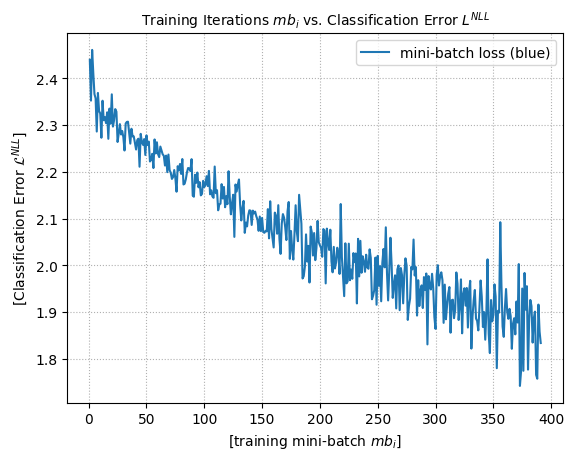

In [30]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_mini_batch_losses)+1)), train_mini_batch_losses, label='mini-batch loss (blue)')

# add axis legends
ax.set_xlabel("[training mini-batch $mb_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Iterations $mb_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Ok, fantastic. The training error converges nicely. We could definitely train the network a couple more epochs until the error converges. But let's keep the 1 training epoch for now and continue with evaluating our trained model.

## 6. Evaluation of the Trained Neural Network Model

We will conduct our evaluation based on a model that was already pre-trained for a total of 200 training epochs. Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load a pre-trained snapshot.

In [33]:
# restore pre-trained model snapshot
best_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/GSERM2023-Lab/master/lab_05_bonus/models/cifar10_resnet_model_epoch_199.pth'

# read stored model from the remote location
model_bytes = urllib.request.urlopen(best_model_name)

# load model tensor from io.BytesIO object
model_buffer = io.BytesIO(model_bytes.read())

# init pre-trained model class
best_resnet_model = ResNet(layers=[2, 2, 2])

# load pre-trained models
best_resnet_model.load_state_dict(torch.load(model_buffer, map_location=torch.device('cpu')))

<All keys matched successfully>

Let's again inspect if the pre-trained model was loaded successfully: 

In [34]:
# set model in evaluation mode
best_resnet_model.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), 

In order to evaluate our trained model, we need to feed the CIFAR10 images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's again define a corresponding PyTorch data loader that feeds the image tensors to our neural network: 

In [35]:
cifar10_eval_dataloader = torch.utils.data.DataLoader(cifar10_eval_data, batch_size=8, shuffle=False)

In [36]:
len(cifar10_eval_dataloader)

1250

Similarly to the **CNN** we implemented in the last lab, we will now evaluate the pre-trained `ResNet` model based on the mini-batches of the evaluation dataset to derive the mean negative log-likelihood loss:

In [ ]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(cifar10_eval_dataloader):

    # run forward pass through the network
    output = best_resnet_model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

Ok, great. The evaluation loss obtained by `ResNet` model looks significantly lower compared to the one achieved by the `CIFAR10Net` model in the **CNN** lab. Let's now inspect a few sample predictions to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [ ]:
# select a sample image id
image_id = 5

# obtain the image from the dataloader
cifar10_eval_image = iter(cifar10_eval_dataloader).next()[0][image_id]

# obtain the true label of the image
label = cifar10_eval_data.targets[image_id]

# obtain the model's class prediction
prediction = torch.argmax(best_resnet_model(cifar10_eval_image.unsqueeze(0)), dim=1).item()

# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}, Prediction: {}'.format(str(image_id), str(cifar10_classes[label]), str(cifar10_classes[prediction])))

# un-normalize cifar 10 image sample
cifar10_eval_image_plot = cifar10_eval_image / 2.0 + 0.5

# plot cifar 10 image sample
plt.imshow(trans(cifar10_eval_image_plot))

Let's now obtain the predictions for all the `CIFAR10` images of the evaluation data using the pre-trained `ResNet`model:

In [ ]:
# init collection of mini-batch losses
predictions = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(cifar10_eval_dataloader):

    # run forward pass through the network
    output = best_resnet_model(images)

    # collect predictons
    batch_predictions = torch.argmax(output, dim=1)

    # print log each 100 evaluation mini-batch
    if i % 100 == 0:

      # print mini-batch loss loss
      now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
      # multiply the number of mini-batches (i) by their size (8 images per mini-batch)
      print('[LOG {}] {} prediction(s) collected'.format(str(now), str(i*8)))

    # collect mini-batch reconstruction loss
    predictions.extend(batch_predictions.detach().numpy().tolist())

print('\nTotal predictions: {}'.format(len(predictions)))

Let's obtain the overall classification accuracy of the trained `ResNet` model:

In [ ]:
metrics.accuracy_score(cifar10_eval_data.targets, predictions)

In addition, let's inspect the confusion matrix of the model predictions to determine major sources of misclassification:

In [ ]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(cifar10_eval_data.targets, predictions)

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title('CIFAR-10 ResNet classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Ok, we can easily see that our current model confuses images of cats and dogs as well as images of trucks and cars quite often. This is again not surprising since those image categories exhibit a high semantic and therefore visual similarity.

## 7. Lab Summary:

In this lab, a step by step introduction into **design, implementation, training and evaluation** of Residual Neural Networks (**RNNs**) to classify tiny images of objects is presented. The code and exercises presented in this lab may serves as a starting point for developing more complex, deeper and more tailored RNNs.

## 8. References

>- 'Deep Residual Learning for Image Recognition' by He, K., Zhang, X., Ren, S., and, Sun, J., 2015
>- 'Dive into Deep Learning' by Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2020). Available at https://d2l.ai/index.html
>- Andrew Ng's classes on YouTube: 'C4W2L03 Resnets' and 'C4W2L04 Why ResNets Work' on the Deeplearning.ai channel. Available at https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w and excellent for those who are not big readers.